#Neural Network
This notebook contains our training of a neural network as an attempt to predict accident severity. Crash Severity can be broken into 5 categories:

K. Fatal Injury

A. Severe Injury

B. Visible Injury

C. Nonvisible Injury

O. Property Damage Only

In [1]:
!pip install tensorflow

In [30]:
import pandas as pd
import re
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix, f1_score, ConfusionMatrixDisplay

import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow import keras


In [3]:
df = pd.read_csv("crash_data.csv", low_memory=False)

In [4]:
df.shape

(1128862, 128)

In [10]:
keep_cols = [
    'Crash_Date','Crash_Military_Time','Intersection_Type','Area_Type',
    'Roadway_Alignment','Light_Condition','Weather_Condition',
    'Roadway_Surface_Condition','Roadway_Surface_Type',
    'Traffic_Control_Type','Traffic_Control_Status','Collision_Type',
    'Speed_Posted','Vehicle_Count','First_Harmful_Event','Crash_Severity'
]
df = df[keep_cols].copy()

In [12]:
df['Crash_Date'] = pd.to_datetime(df['Crash_Date'])
df['day_of_week'] = df['Crash_Date'].dt.day_name()

In [13]:
def extract_hour(t):
    s = str(int(t)).zfill(4)
    return int(s[:2])
df['hour_of_day'] = df['Crash_Military_Time'].apply(extract_hour)

bins = [0, 6, 12, 18, 24]
labels = ['Night','Morning','Afternoon','Evening']
df['time_of_day'] = pd.cut(df['hour_of_day'], bins=bins, labels=labels, right=False)

In [14]:
def parse_max_speed(s):
    if pd.isna(s):
        return np.nan
    nums = [int(x) for x in re.findall(r'\d+', s)]
    return max(nums) if nums else np.nan

df['Speed_Posted_max'] = df['Speed_Posted'].apply(parse_max_speed)

In [15]:
df = df.drop(columns=['Crash_Date','Crash_Military_Time','Speed_Posted','hour_of_day'])

In [16]:
X = df.drop(columns=['Crash_Severity'])
y = df['Crash_Severity']

In [17]:
le = LabelEncoder()
y_enc = le.fit_transform(y)

print(y_enc)

[4 4 1 ... 1 1 4]


In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc,
    test_size=0.30,
    stratify=y_enc,
    random_state=42
)

In [19]:
numeric_feats = ['Vehicle_Count','Speed_Posted_max']
numeric_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])

categorical_feats = [
    'Intersection_Type','Area_Type','Roadway_Alignment',
    'Light_Condition','Weather_Condition',
    'Roadway_Surface_Condition','Roadway_Surface_Type',
    'Traffic_Control_Type','Traffic_Control_Status',
    'Collision_Type','First_Harmful_Event',
    'day_of_week','time_of_day',
]
categorical_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipe, numeric_feats),
    ('cat', categorical_pipe, categorical_feats)
])

#Data Preparation



In [20]:
y_class_names = ['O', 'B', 'C', 'A', 'K']


X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
y_train_processed = y_train
y_test_processed = y_test

X_valid = X_train_processed[:5000]
new_X_train = X_train_processed[5000:]
y_valid = y_train[:5000]
new_y_train = y_train[5000:]



#Model Creation


In [21]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[new_X_train.shape[1]]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 148)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 300)            │        44,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,810 (296.13 KB)

 Trainable params: 75,810 (296.13 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=[keras.metrics.sparse_categorical_accuracy])

#Training

In [24]:
history = model.fit(new_X_train, new_y_train, batch_size=64, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
12269/12269 ━━━━━━━━━━━━━━━━━━━━ 61s 5ms/step - loss: 0.9096 - sparse_categorical_accuracy: 0.6775 - val_loss: 0.8847 - val_sparse_categorical_accuracy: 0.6832
Epoch 2/30
12269/12269 ━━━━━━━━━━━━━━━━━━━━ 60s 5ms/step - loss: 0.8953 - sparse_categorical_accuracy: 0.6803 - val_loss: 0.8824 - val_sparse_categorical_accuracy: 0.6824
Epoch 3/30
12269/12269 ━━━━━━━━━━━━━━━━━━━━ 65s 5ms/step - loss: 0.8908 - sparse_categorical_accuracy: 0.6815 - val_loss: 0.8792 - val_sparse_categorical_accuracy: 0.6834
Epoch 4/30
12269/12269 ━━━━━━━━━━━━━━━━━━━━ 62s 5ms/step - loss: 0.8906 - sparse_categorical_accuracy: 0.6813 - val_loss: 0.8804 - val_sparse_categorical_accuracy: 0.6852
Epoch 5/30
12269/12269 ━━━━━━━━━━━━━━━━━━━━ 94s 6ms/step - loss: 0.8886 - sparse_categorical_accuracy: 0.6821 - val_loss: 0.8788 - val_sparse_categorical_accuracy: 0.6842
Epoch 6/30
12269/12269 ━━━━━━━━━━━━━━━━━━━━ 63s 5ms/step - loss: 0.8867 - sparse_categorical_accuracy: 0.6822 - val_loss: 0.8767 - val_sparse_cat

#Results

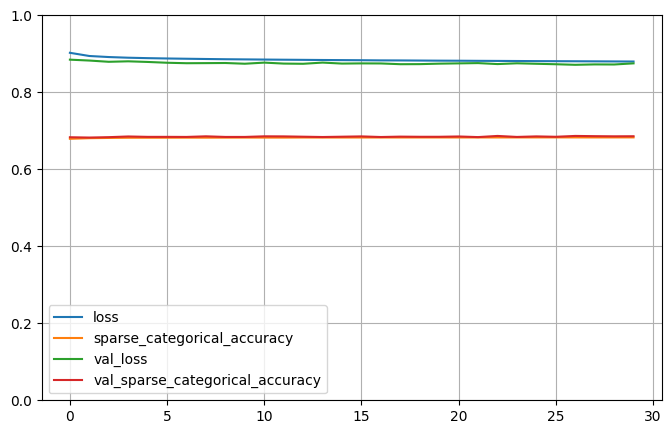

In [26]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

10584/10584 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step
Accuracy: 0.6818
F1 Score (macro): 0.2077


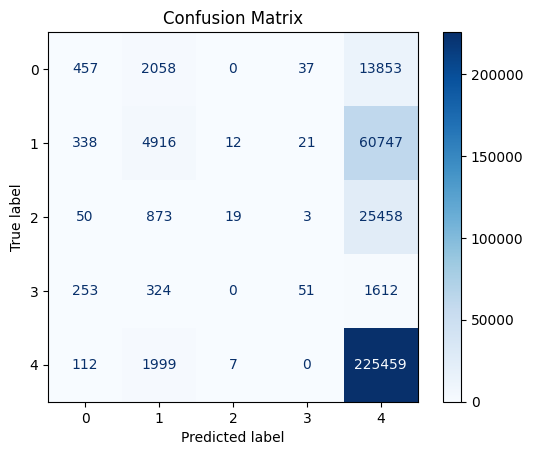

In [31]:
if len(y_test.shape) > 1 and y_test.shape[1] > 1:
    y_test_labels = np.argmax(y_test, axis=1)
else:
    y_test_labels = y_test

    y_pred_probs = model.predict(X_test_processed)

y_pred_labels = np.argmax(y_pred_probs, axis=1)

acc = accuracy_score(y_test_labels, y_pred_labels)
print(f"Accuracy: {acc:.4f}")

f1 = f1_score(y_test_labels, y_pred_labels, average='macro')
print(f"F1 Score (macro): {f1:.4f}")

cm = confusion_matrix(y_test_labels, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()